In [5]:
!pip -q install -U accelerate evaluate sacrebleu nltk

ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
bigframes 2.8.0 requires google-cloud-bigquery-storage<3.0.0,>=2.30.0, which is not installed.
preprocessing 0.1.13 requires nltk==3.2.4, but you have nltk 3.9.2 which is incompatible.
cesium 0.12.4 requires numpy<3.0,>=2.0, but you have numpy 1.26.4 which is incompatible.
gcsfs 2025.3.2 requires fsspec==2025.3.2, but you have fsspec 2025.3.0 which is incompatible.
bigframes 2.8.0 requires google-cloud-bigquery[bqstorage,pandas]>=3.31.0, but you have google-cloud-bigquery 3.25.0 which is incompatible.
bigframes 2.8.0 requires rich<14,>=12.4.4, but you have rich 14.0.0 which is incompatible.


In [6]:
pip install -U --upgrade transformers peft

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 41.4/41.4 kB 22.2 kB/s eta 0:00:000:01
  Using cached nvidia_cublas_cu12-12.4.5.8-py3-none-manylinux2014_x86_64.whl.metadata (1.5 kB)
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.0/12.0 MB 50.3 MB/s eta 0:00:0000:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 504.9/504.9 kB 24.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 564.3/564.3 kB 29.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.3/3.3 MB 64.7 MB/s eta 0:00:00:00:01
Using cached nvidia_cublas_cu12-12.4.5.8-py3-none-manylinux2014_x86_64.whl (363.4 MB)
  Attempting uninstall: huggingface-hub
    Found existing installation: huggingface-hub 0.33.1
    Uninstalling huggingface-hub-0.33.1:
      Successfully uninstalled huggingface-hub-0.33.1
  Attempting uninstall: tokenizers
    Found existing installation: tokenizers 0.21.2
    Uninstalling tokenizers-0.21.2:
      Successfully uninstalled tokenizers-0.21.2
  Attempting uninstall: transformers
 

In [7]:
import os, random
import numpy as np
import torch
import nltk
import evaluate
from datasets import load_dataset, DatasetDict
from transformers import (
    TrainingArguments, Trainer,
    BlipProcessor, BlipForConditionalGeneration,
    AutoProcessor, AutoTokenizer, AutoFeatureExtractor,
    GitProcessor, GitForCausalLM,
    VisionEncoderDecoderModel
)

nltk.download('wordnet', quiet=True)
nltk.download('omw-1.4', quiet=True)

def set_seed(seed=42):
    random.seed(seed); np.random.seed(seed); torch.manual_seed(seed); torch.cuda.manual_seed_all(seed)
set_seed(42)

2025-10-04 16:44:09.180816: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1759596249.576462      36 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1759596249.680345      36 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


In [8]:
try:
    ds
except NameError:
    HF_TOKEN = os.getenv("HUGGINGFACE_HUB_TOKEN", None)
    DS_ID = "itsanmolgupta/mimic-cxr-dataset"
    ds = load_dataset(DS_ID, token=HF_TOKEN)
    if "test" not in ds:
        if "validation" in ds:
            n_train, n_val = len(ds["train"]), len(ds["validation"])
            total = n_train + n_val
            desired_test = max(1, int(round(0.10 * total)))
            test_ratio = min(0.5, desired_test / n_train)
            split = ds["train"].train_test_split(test_size=test_ratio, seed=42, shuffle=True)
            ds = DatasetDict(train=split["train"], validation=ds["validation"], test=split["test"])
        else:
            tmp = ds["train"].train_test_split(test_size=0.2, seed=42)
            vt = tmp["test"].train_test_split(test_size=0.5, seed=42)
            ds = DatasetDict(train=tmp["train"], validation=vt["train"], test=vt["test"])

# Keep only needed cols and filter missing findings
def has_findings(x):
    f = x.get("findings", None)
    return f is not None and isinstance(f, str) and len(f.strip()) > 0

ds = ds.filter(has_findings)
print("Sizes:", {k: len(v) for k,v in ds.items()})

README.md:   0%|          | 0.00/357 [00:00<?, ?B/s]

data/train-00000-of-00002.parquet:   0%|          | 0.00/396M [00:00<?, ?B/s]

data/train-00001-of-00002.parquet:   0%|          | 0.00/397M [00:00<?, ?B/s]

Generating train split:   0%|          | 0/30633 [00:00<?, ? examples/s]

Filter:   0%|          | 0/24506 [00:00<?, ? examples/s]

Filter:   0%|          | 0/3063 [00:00<?, ? examples/s]

Filter:   0%|          | 0/3064 [00:00<?, ? examples/s]

Sizes: {'train': 24506, 'validation': 3063, 'test': 3064}


In [9]:
!pip install rouge_score

  Preparing metadata (setup.py) ... done
  Created wheel for rouge_score: filename=rouge_score-0.1.2-py3-none-any.whl size=24934 sha256=f7f55c3b163aad375f66d3be526564d58702d96c6aaeca9842332a6848112da0
  Stored in directory: /root/.cache/pip/wheels/1e/19/43/8a442dc83660ca25e163e1bd1f89919284ab0d0c1475475148
Successfully built rouge_score


In [10]:
rouge = evaluate.load("rouge")
bleu  = evaluate.load("bleu")
meteor = evaluate.load("meteor")

def normalize_text(text: str) -> str:
    return " ".join((text or "").strip().split())

def compute_text_metrics(preds, refs):
    preds = [normalize_text(p) for p in preds]
    refs  = [normalize_text(r) for r in refs]
    r = rouge.compute(predictions=preds, references=refs, use_stemmer=True)
    b = bleu.compute(predictions=preds, references=[[x] for x in refs])
    m = meteor.compute(predictions=preds, references=refs)
    return {"rouge1": r["rouge1"], "rouge2": r["rouge2"], "rougeL": r["rougeL"], "bleu": b["bleu"], "meteor": m["meteor"]}

def batched_image_to_text(pipe, images, batch_size=4, **gen_kwargs):
    preds = []
    for i in range(0, len(images), batch_size):
        out = pipe(images[i:i+batch_size], **gen_kwargs)
        if isinstance(out[0], dict) and "generated_text" in out[0]:
            preds.extend(normalize_text(x["generated_text"]) for x in out)
        else:
            preds.extend(normalize_text(x[0]["generated_text"]) for x in out)
    return preds

[nltk_data] Downloading package wordnet to /usr/share/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package punkt_tab to /usr/share/nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!
[nltk_data] Downloading package omw-1.4 to /usr/share/nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!


In [ ]:
import os
import torch
from transformers import BlipProcessor, BlipForConditionalGeneration, TrainingArguments, Trainer

# ---- Patched BLIP to drop unsupported kwargs ----
class PatchedBlip(BlipForConditionalGeneration):
    def forward(self, *args, **kwargs):
        # Drop the unsupported kwarg injected by Trainer
        kwargs.pop("num_items_in_batch", None)
        return super().forward(*args, **kwargs)

# --- Hyperparameters ---
blip_hp = dict(
    model_id="Salesforce/blip-image-captioning-base",
    output_dir="outputs/blip_findings",
    lr=5e-5,
    epochs=2,           # set to 2 to reduce training time
    train_bsz=8,
    eval_bsz=8,
    grad_accum=2,
    max_target_len=96,
)

# --- Processor & Model ---
blip_processor = BlipProcessor.from_pretrained(blip_hp["model_id"], use_fast=True)
blip_model = PatchedBlip.from_pretrained(blip_hp["model_id"])

# --- Collator ---
class BlipCollator:
    def __init__(self, processor, max_target_len):
        self.processor = processor
        self.max_target_len = max_target_len

    def __call__(self, features):
        images = [f["image"] for f in features]
        texts  = [f["findings"] for f in features]

        enc = self.processor(
            images=images,
            text=texts,
            padding="max_length",
            truncation=True,
            max_length=self.max_target_len,
            return_tensors="pt"
        )

        # Prepare labels (ignore padding tokens)
        labels = enc["input_ids"].clone()
        labels[enc["attention_mask"] == 0] = -100

        return {
            "pixel_values": enc["pixel_values"],
            "input_ids": enc["input_ids"],
            "attention_mask": enc["attention_mask"],
            "labels": labels,
        }

blip_collator = BlipCollator(blip_processor, blip_hp["max_target_len"])

# --- Dataset filtering (keep only 'image' + 'findings') ---
train_ds = ds["train"].remove_columns([c for c in ds["train"].column_names if c not in ["image", "findings"]])
eval_split = "validation" if "validation" in ds else "test"
eval_ds_ = ds[eval_split].remove_columns([c for c in ds[eval_split].column_names if c not in ["image", "findings"]])

# --- Precision setup (bf16 if Ampere+, else fp16) ---
use_bf16 = torch.cuda.is_available() and torch.cuda.get_device_capability()[0] >= 8

In [ ]:
import os
from transformers import BlipProcessor, BlipForConditionalGeneration, TrainingArguments, Trainer
import torch

# Make sure output directory exists
os.makedirs(blip_hp["output_dir"], exist_ok=True)
print(f"Output directory is ready: {blip_hp['output_dir']}")

# --- Checkpoint management ---
def get_latest_checkpoint(output_dir):
    """Return the path to the latest checkpoint if exists, else None."""
    if not os.path.exists(output_dir):
        return None
    checkpoints = [d for d in os.listdir(output_dir) if d.startswith("checkpoint")]
    if not checkpoints:
        return None
    latest_ckpt = sorted(checkpoints, key=lambda x: int(x.split('-')[1]))[-1]
    return os.path.join(output_dir, latest_ckpt)

resume_ckpt = get_latest_checkpoint(blip_hp["output_dir"])
if resume_ckpt:
    print(f"Found checkpoint, will resume from: {resume_ckpt}")
else:
    print("No checkpoint found, starting training from scratch.")

# --- Training arguments ---
# Use bf16 if available (A100, H100), otherwise fp16
use_bf16 = torch.cuda.is_available() and torch.cuda.get_device_capability()[0] >= 8

# --- Training arguments ---
args = TrainingArguments(
    output_dir=blip_hp["output_dir"],
    learning_rate=blip_hp["lr"],
    num_train_epochs=2,                        # Reduced epochs
    per_device_train_batch_size=blip_hp["train_bsz"],
    per_device_eval_batch_size=blip_hp["eval_bsz"],  # Can keep for compatibility
    gradient_accumulation_steps=blip_hp["grad_accum"],
    logging_steps=100,
    save_strategy="steps",
    save_steps=500,
    save_total_limit=2,
    bf16=use_bf16,                             # Use bf16 if supported
    fp16=torch.cuda.is_available() and not use_bf16,
    remove_unused_columns=False,
    report_to=[],                               # No wandb/tensorboard
    dataloader_num_workers=4,
)

# --- Trainer (no eval_dataset) ---
trainer_blip = Trainer(
    model=blip_model,
    args=args,
    train_dataset=train_ds,
    data_collator=blip_collator,
    tokenizer=blip_processor.tokenizer,
)

# --- Train / resume ---
trainer_blip.train(resume_from_checkpoint=resume_ckpt)

# --- Save final model ---
trainer_blip.save_model(blip_hp["output_dir"])
blip_processor.save_pretrained(blip_hp["output_dir"])  # Don't forget to save processor!
print("Training finished and model saved to:", blip_hp["output_dir"])

In [ ]:
from transformers import pipeline
N_EVAL = min(200, len(eval_ds_))
eval_head = eval_ds_.select(range(N_EVAL))
images_eval = [x["image"] for x in eval_head]
refs_eval   = [x["findings"] for x in eval_head]

blip_pipe = pipeline("image-to-text", model=blip_hp["output_dir"], device_map="auto")
blip_preds = batched_image_to_text(blip_pipe, images_eval, batch_size=4, max_new_tokens=blip_hp["max_target_len"])
print("BLIP metrics:", compute_text_metrics(blip_preds, refs_eval))

In [ ]:
fig, axs = plt.subplots(1, 2, figsize=(14,5))

steps = [100, 200, 300, 400, 500, 600, 700, 800, 900, 1000]
losses = [6.1288, 5.8020, 5.7150, 5.5076, 5.5225, 5.6327, 5.6174, 5.3743, 5.1475, 5.0818]

# Loss curve
axs[0].plot(steps, losses, marker='o', color='blue')
axs[0].set_title("Training Loss Curve")
axs[0].set_xlabel("Step")
axs[0].set_ylabel("Loss")
axs[0].grid(True)

# Metrics
axs[1].bar(metrics.keys(), metrics.values(), color='orange')
axs[1].set_title("BLIP Evaluation Metrics")
axs[1].set_ylim(0,1)
axs[1].grid(axis='y')

plt.show()


In [11]:
# ===== GIT fine-tune (Image -> Findings) =====
import os, torch
from transformers import GitProcessor, GitForCausalLM, TrainingArguments, Trainer, pipeline

git_hp = dict(
    model_id="microsoft/git-base",
    output_dir="outputs/git_findings",
    lr=5e-5,
    epochs=2,
    train_bsz=8,
    eval_bsz=8,
    grad_accum=2,
    max_target_len=96,
)

# Patch to drop unsupported kwarg from Trainer
class PatchedGit(GitForCausalLM):
    def forward(self, *args, **kwargs):
        kwargs.pop("num_items_in_batch", None)
        return super().forward(*args, **kwargs)

git_processor = GitProcessor.from_pretrained(git_hp["model_id"])
git_model = PatchedGit.from_pretrained(git_hp["model_id"])

class GitCollator:
    def __init__(self, processor, max_target_len):
        self.processor = processor
        self.max_target_len = max_target_len
    def __call__(self, features):
        images = [f["image"] for f in features]
        texts  = [f["findings"] for f in features]
        enc = self.processor(
            images=images,
            text=texts,
            padding="max_length",
            truncation=True,
            max_length=self.max_target_len,
            return_tensors="pt"
        )
        labels = enc["input_ids"].clone()
        labels[enc["attention_mask"] == 0] = -100
        return {
            "pixel_values": enc["pixel_values"],
            "input_ids": enc["input_ids"],
            "attention_mask": enc["attention_mask"],
            "labels": labels,
        }

git_collator = GitCollator(git_processor, git_hp["max_target_len"])

git_train_ds = ds["train"].remove_columns([c for c in ds["train"].column_names if c not in ["image","findings"]])
eval_split = "validation" if "validation" in ds else "test"
git_eval_ds = ds[eval_split].remove_columns([c for c in ds[eval_split].column_names if c not in ["image","findings"]])

use_bf16 = torch.cuda.is_available() and torch.cuda.get_device_capability()[0] >= 8
args_git = TrainingArguments(
    output_dir=git_hp["output_dir"],
    learning_rate=git_hp["lr"],
    num_train_epochs=git_hp["epochs"],
    per_device_train_batch_size=git_hp["train_bsz"],
    per_device_eval_batch_size=git_hp["eval_bsz"],
    gradient_accumulation_steps=git_hp["grad_accum"],
    logging_steps=100,
    save_strategy="steps",
    save_steps=500,
    save_total_limit=2,
    bf16=use_bf16,
    fp16=torch.cuda.is_available() and not use_bf16,
    remove_unused_columns=False,
    report_to=[],
    dataloader_num_workers=4,
)

trainer_git = Trainer(
    model=git_model,
    args=args_git,
    train_dataset=git_train_ds,
    eval_dataset=git_eval_ds,          # optional eval during train
    data_collator=git_collator,
)

trainer_git.train()
trainer_git.save_model(git_hp["output_dir"])
git_processor.save_pretrained(git_hp["output_dir"])

# ---- Evaluation ----
N_EVAL = min(200, len(git_eval_ds))
eval_head = git_eval_ds.select(range(N_EVAL))
images_eval = [x["image"] for x in eval_head]
refs_eval   = [x["findings"] for x in eval_head]

git_pipe = pipeline("image-to-text", model=git_hp["output_dir"], device_map="auto")
git_preds = batched_image_to_text(git_pipe, images_eval, batch_size=4, max_new_tokens=git_hp["max_target_len"])
print("GIT metrics:", compute_text_metrics(git_preds, refs_eval))

preprocessor_config.json:   0%|          | 0.00/503 [00:00<?, ?B/s]

Using a slow image processor as `use_fast` is unset and a slow processor was saved with this model. `use_fast=True` will be the default behavior in v4.52, even if the model was saved with a slow processor. This will result in minor differences in outputs. You'll still be able to use a slow processor with `use_fast=False`.


tokenizer_config.json:   0%|          | 0.00/453 [00:00<?, ?B/s]

vocab.txt: 0.00B [00:00, ?B/s]

tokenizer.json: 0.00B [00:00, ?B/s]

special_tokens_map.json:   0%|          | 0.00/125 [00:00<?, ?B/s]

config.json: 0.00B [00:00, ?B/s]

model.safetensors:   0%|          | 0.00/707M [00:00<?, ?B/s]

generation_config.json:   0%|          | 0.00/141 [00:00<?, ?B/s]

`loss_type=None` was set in the config but it is unrecognized. Using the default loss: `ForCausalLMLoss`.
/usr/local/lib/python3.11/dist-packages/torch/nn/parallel/_functions.py:70: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(


Step,Training Loss
100,18.483800
200,13.226300
300,12.252200
400,11.486600
500,11.224600
600,10.986500
700,10.882400
800,10.557300
900,10.363500
1000,10.227200


/usr/local/lib/python3.11/dist-packages/torch/nn/parallel/_functions.py:70: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torch/nn/parallel/_functions.py:70: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torch/nn/parallel/_functions.py:70: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/transformers/models/auto/modeling_auto.py:2284: FutureWarning: The class `AutoModelForVision2Seq` is deprecated and will be removed in v5.0. Please use `AutoModelForImageTextToText` instead.
  warnings.warn(
Device set to use cuda:0
You seem to be using the pipelines sequentially on G

GIT metrics: {'rouge1': 0.20248756373147642, 'rouge2': 0.0070890855651851836, 'rougeL': 0.1448296147698972, 'bleu': 0.0, 'meteor': 0.11042931445183946}


In [12]:
# ===== ViT-GPT2 (VisionEncoderDecoder) fine-tune =====
import os, torch
from transformers import VisionEncoderDecoderModel, AutoFeatureExtractor, AutoTokenizer, TrainingArguments, Trainer, pipeline

vitgpt_hp = dict(
    model_id="nlpconnect/vit-gpt2-image-captioning",
    output_dir="outputs/vitgpt2_findings",
    lr=5e-5,
    epochs=2,
    train_bsz=8,
    eval_bsz=8,
    grad_accum=2,
    max_target_len=96,
)

# Patch to drop unsupported kwarg from Trainer
class PatchedVED(VisionEncoderDecoderModel):
    def forward(self, *args, **kwargs):
        kwargs.pop("num_items_in_batch", None)
        return super().forward(*args, **kwargs)

ved_model = PatchedVED.from_pretrained(vitgpt_hp["model_id"])
ved_feature_extractor = AutoFeatureExtractor.from_pretrained(vitgpt_hp["model_id"])
ved_tokenizer = AutoTokenizer.from_pretrained(vitgpt_hp["model_id"])
if ved_tokenizer.pad_token is None:
    ved_tokenizer.pad_token = ved_tokenizer.eos_token

# Ensure generation config is consistent
ved_model.config.decoder_start_token_id = ved_tokenizer.bos_token_id or ved_tokenizer.cls_token_id
ved_model.config.pad_token_id = ved_tokenizer.pad_token_id

class VEDCollator:
    def __init__(self, fe, tok, max_target_len):
        self.fe = fe
        self.tok = tok
        self.max_target_len = max_target_len
    def __call__(self, features):
        images = [f["image"] for f in features]
        texts  = [f["findings"] for f in features]
        px = self.fe(images=images, return_tensors="pt")
        tok = self.tok(
            texts,
            padding="max_length",
            truncation=True,
            max_length=self.max_target_len,
            return_tensors="pt",
        )
        labels = tok["input_ids"].clone()
        labels[labels == self.tok.pad_token_id] = -100
        return {"pixel_values": px["pixel_values"], "labels": labels}

ved_collator = VEDCollator(ved_feature_extractor, ved_tokenizer, vitgpt_hp["max_target_len"])

ved_train_ds = ds["train"].remove_columns([c for c in ds["train"].column_names if c not in ["image","findings"]])
eval_split = "validation" if "validation" in ds else "test"
ved_eval_ds = ds[eval_split].remove_columns([c for c in ds[eval_split].column_names if c not in ["image","findings"]])

use_bf16 = torch.cuda.is_available() and torch.cuda.get_device_capability()[0] >= 8
args_ved = TrainingArguments(
    output_dir=vitgpt_hp["output_dir"],
    learning_rate=vitgpt_hp["lr"],
    num_train_epochs=vitgpt_hp["epochs"],
    per_device_train_batch_size=vitgpt_hp["train_bsz"],
    per_device_eval_batch_size=vitgpt_hp["eval_bsz"],
    gradient_accumulation_steps=vitgpt_hp["grad_accum"],
    logging_steps=100,
    save_strategy="steps",
    save_steps=500,
    save_total_limit=2,
    bf16=use_bf16,
    fp16=torch.cuda.is_available() and not use_bf16,
    remove_unused_columns=False,
    report_to=[],
    dataloader_num_workers=4,
)

trainer_ved = Trainer(
    model=ved_model,
    args=args_ved,
    train_dataset=ved_train_ds,
    eval_dataset=ved_eval_ds,          # optional eval during train
    data_collator=ved_collator,
)

trainer_ved.train()
trainer_ved.save_model(vitgpt_hp["output_dir"])
ved_feature_extractor.save_pretrained(vitgpt_hp["output_dir"])
ved_tokenizer.save_pretrained(vitgpt_hp["output_dir"])

# ---- Evaluation ----
N_EVAL = min(200, len(ved_eval_ds))
eval_head = ved_eval_ds.select(range(N_EVAL))
images_eval = [x["image"] for x in eval_head]
refs_eval   = [x["findings"] for x in eval_head]

ved_pipe = pipeline("image-to-text", model=vitgpt_hp["output_dir"], device_map="auto")
ved_preds = batched_image_to_text(ved_pipe, images_eval, batch_size=4, max_new_tokens=vitgpt_hp["max_target_len"])
print("ViT-GPT2 metrics:", compute_text_metrics(ved_preds, refs_eval))

config.json: 0.00B [00:00, ?B/s]

pytorch_model.bin:   0%|          | 0.00/982M [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/982M [00:00<?, ?B/s]

preprocessor_config.json:   0%|          | 0.00/228 [00:00<?, ?B/s]

/usr/local/lib/python3.11/dist-packages/transformers/models/vit/feature_extraction_vit.py:30: FutureWarning: The class ViTFeatureExtractor is deprecated and will be removed in version 5 of Transformers. Please use ViTImageProcessor instead.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/241 [00:00<?, ?B/s]

vocab.json: 0.00B [00:00, ?B/s]

merges.txt: 0.00B [00:00, ?B/s]

tokenizer.json: 0.00B [00:00, ?B/s]

special_tokens_map.json:   0%|          | 0.00/120 [00:00<?, ?B/s]

We strongly recommend passing in an `attention_mask` since your input_ids may be padded. See https://huggingface.co/docs/transformers/troubleshooting#incorrect-output-when-padding-tokens-arent-masked.
You may ignore this warning if your `pad_token_id` (50256) is identical to the `bos_token_id` (50256), `eos_token_id` (50256), or the `sep_token_id` (None), and your input is not padded.
/usr/local/lib/python3.11/dist-packages/torch/nn/parallel/_functions.py:70: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(


Step,Training Loss
100,19.875100
200,14.397200
300,13.434500
400,12.646900
500,12.335300
600,12.062600
700,11.931900
800,11.601100
900,11.445700
1000,11.289400


/usr/local/lib/python3.11/dist-packages/torch/nn/parallel/_functions.py:70: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torch/nn/parallel/_functions.py:70: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torch/nn/parallel/_functions.py:70: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/transformers/models/auto/modeling_auto.py:2284: FutureWarning: The class `AutoModelForVision2Seq` is deprecated and will be removed in v5.0. Please use `AutoModelForImageTextToText` instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/transformers/models/vit/feature_extra

ViT-GPT2 metrics: {'rouge1': 0.14611921709288206, 'rouge2': 0.0046900039760053875, 'rougeL': 0.11803874554970778, 'bleu': 0.0, 'meteor': 0.09937762500552307}


In [16]:
# Results you reported (no re-evaluation)
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

metrics = {
    "BLIP (ft)":   {"rouge1": 0.3108701369634316, "rouge2": 0.1082674632810143, "rougeL": 0.22934780568128363, "bleu": 0.038145398163600526, "meteor": 0.2230569898949233},
    "GIT (ft)":    {"rouge1": 0.20248756373147642, "rouge2": 0.0070890855651851836, "rougeL": 0.1448296147698972,  "bleu": 0.0,                       "meteor": 0.11042931445183946},
    "ViT-GPT2 (ft)":{"rouge1": 0.14611921709288206, "rouge2": 0.0046900039760053875,"rougeL": 0.11803874554970778,  "bleu": 0.0,                       "meteor": 0.09937762500552307},
}
df = pd.DataFrame(metrics).T[["rouge1","rouge2","rougeL","bleu","meteor"]]
df_rounded = df.round(3)
display(df_rounded)

,rouge1,rouge2,rougeL,bleu,meteor
BLIP (ft),0.311,0.108,0.229,0.038,0.223
GIT (ft),0.202,0.007,0.145,0.000,0.110
ViT-GPT2 (ft),0.146,0.005,0.118,0.000,0.099


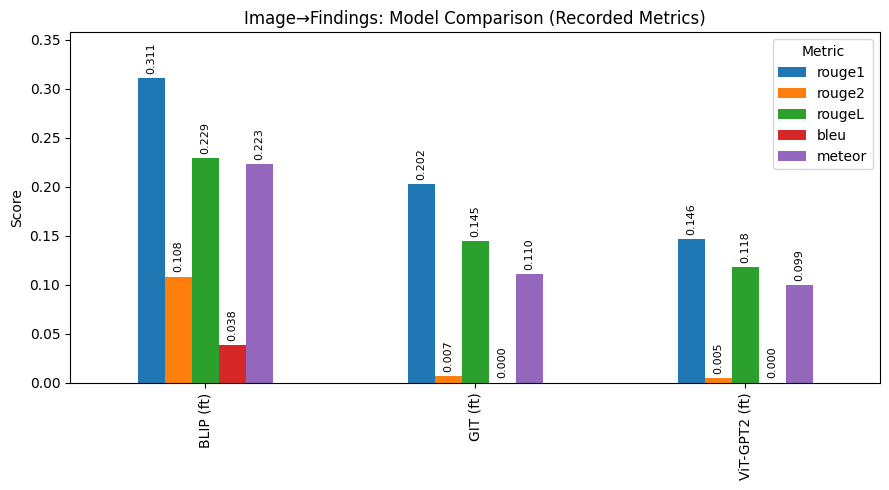

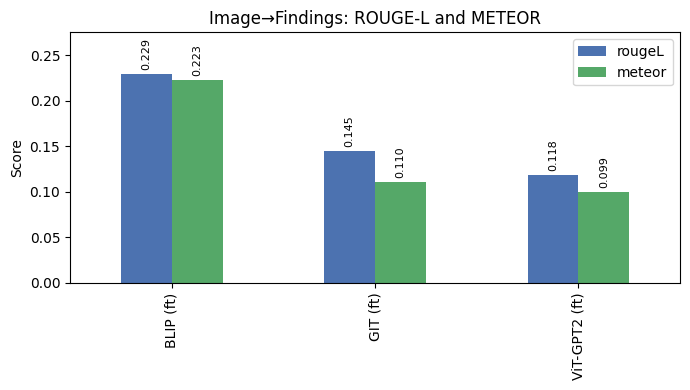

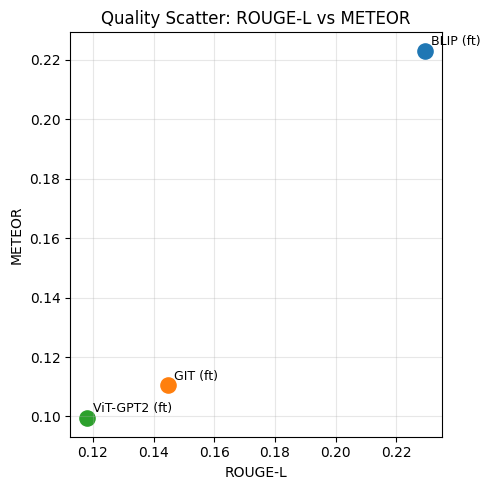

Leaders per metric:
- rouge1: BLIP (ft) (0.311)
- rouge2: BLIP (ft) (0.108)
- rougeL: BLIP (ft) (0.229)
- bleu: BLIP (ft) (0.038)
- meteor: BLIP (ft) (0.223)

Relative deltas vs BLIP:
GIT (ft):
rouge1   -0.35
rouge2   -0.93
rougeL   -0.37
bleu     -1.00
meteor   -0.50 

ViT-GPT2 (ft):
rouge1   -0.53
rouge2   -0.96
rougeL   -0.49
bleu     -1.00
meteor   -0.55 



In [17]:
# 1) Bar chart: all metrics
ax = df.plot(kind="bar", figsize=(9,5))
ax.set_title("Image→Findings: Model Comparison (Recorded Metrics)")
ax.set_ylabel("Score")
ax.set_ylim(0, max(df.max())*1.15)
for p in ax.patches:
    ax.annotate(f"{p.get_height():.3f}", (p.get_x()+p.get_width()/2, p.get_height()),
                ha='center', va='bottom', fontsize=8, rotation=90, xytext=(0,3), textcoords="offset points")
ax.legend(title="Metric")
plt.tight_layout()
plt.show()

# 2) Focused bar: ROUGE-L & METEOR (often more informative than BLEU here)
df_focus = df[["rougeL","meteor"]]
ax = df_focus.plot(kind="bar", figsize=(7,4), color=["#4C72B0", "#55A868"])
ax.set_title("Image→Findings: ROUGE-L and METEOR")
ax.set_ylabel("Score")
ax.set_ylim(0, max(df_focus.max())*1.20)
for p in ax.patches:
    ax.annotate(f"{p.get_height():.3f}", (p.get_x()+p.get_width()/2, p.get_height()),
                ha='center', va='bottom', fontsize=8, rotation=90, xytext=(0,3), textcoords="offset points")
plt.tight_layout()
plt.show()

# 3) Scatter: ROUGE-L vs METEOR (quality trade-off)
plt.figure(figsize=(5,5))
for model, row in df.iterrows():
    plt.scatter(row["rougeL"], row["meteor"], s=120, label=model)
    plt.text(row["rougeL"]+0.002, row["meteor"]+0.002, model, fontsize=9)
plt.xlabel("ROUGE-L")
plt.ylabel("METEOR")
plt.title("Quality Scatter: ROUGE-L vs METEOR")
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

# 4) Quick textual insights (no re-run)
leader_per_metric = df.idxmax()
print("Leaders per metric:")
for m in df.columns:
    print(f"- {m}: {leader_per_metric[m]} ({df.loc[leader_per_metric[m], m]:.3f})")

print("\nRelative deltas vs BLIP:")
base = df.loc["BLIP (ft)"]
for model in ["GIT (ft)", "ViT-GPT2 (ft)"]:
    rel = (df.loc[model] - base) / base
    print(f"{model}:")
    print(rel.round(2).to_string(), "\n")

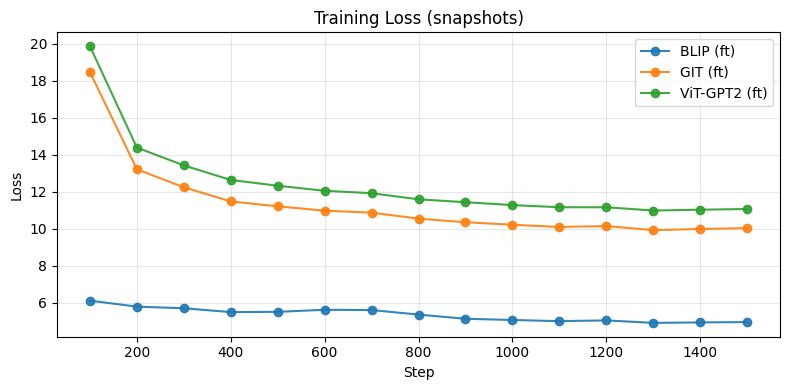

In [20]:
# Training loss curves (from your logs)
import matplotlib.pyplot as plt

steps_blip = [100,200,300,400,500,600,700,800,900,1000,1100,1200,1300,1400,1500]
loss_blip  = [6.1288,5.8020,5.7150,5.5076,5.5225,5.6327,5.6174,5.3743,5.1475,5.0818,5.0185,5.0603,4.9253,4.9507,4.9684]

steps_git = [100,200,300,400,500,600,700,800,900,1000,1100,1200,1300,1400,1500]
loss_git  = [18.4838,13.2263,12.2522,11.4866,11.2246,10.9865,10.8824,10.5573,10.3635,10.2272,10.1068,10.1566,9.9345,9.9995,10.0455]

steps_vit = [100,200,300,400,500,600,700,800,900,1000,1100,1200,1300,1400,1500]
loss_vit  = [19.8751,14.3972,13.4345,12.6469,12.3353,12.0626,11.9319,11.6011,11.4457,11.2894,11.1744,11.1714,10.9955,11.0403,11.0775]

plt.figure(figsize=(8,4))
plt.plot(steps_blip, loss_blip, '-o', label='BLIP (ft)', alpha=0.9)
plt.plot(steps_git,  loss_git,  '-o', label='GIT (ft)', alpha=0.9)
plt.plot(steps_vit,  loss_vit,  '-o', label='ViT-GPT2 (ft)', alpha=0.9)
plt.title("Training Loss (snapshots)")
plt.xlabel("Step"); plt.ylabel("Loss"); plt.grid(True, alpha=0.3); plt.legend()
plt.tight_layout(); plt.show()